In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq, least_squares
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

In [40]:
transformed_data = pd.read_csv("discount_factors.csv")

transformed_data

,Tenor,OIS Table Product,OIS Rate,OIS Forward Rate,OIS Discount Factor,IRS Table Product,IRS Rate,LIBOR Forward Rate,LIBOR Discount Factor
0,0.5,OIS,0.00250,0.002498,0.998752,LIBOR,0.0250,0.025000,0.987654
1,1.0,OIS,0.00300,0.003493,0.997009,IRS,0.0280,0.031005,0.972577
2,2.0,OIS,0.00325,0.003495,0.993531,IRS,0.0300,0.032263,0.942179
3,3.0,OIS,0.00335,0.003545,0.990015,IRS,0.0315,0.034814,0.910482
4,4.0,OIS,0.00350,0.003946,0.986117,IRS,0.0325,0.035838,0.878981
5,5.0,OIS,0.00360,0.003996,0.982184,IRS,0.0330,0.035326,0.848989
6,7.0,OIS,0.00400,0.005015,0.972406,IRS,0.0350,0.041298,0.784216
7,10.0,OIS,0.00450,0.005712,0.955977,IRS,0.0370,0.044033,0.692710
8,15.0,OIS,0.00500,0.006097,0.927611,IRS,0.0400,0.051401,0.551081
9,20.0,OIS,0.00525,0.006100,0.900076,IRS,0.0450,0.069994,0.408218


In [41]:
params_df = pd.read_csv("calibrated_params.csv")

In [42]:
fsr = pd.read_csv("par_swap_rate.csv")
fsr.set_index('Unnamed: 0', inplace=True)
fsr = fsr.T.unstack().reset_index(name='forward_swap_rate')
fsr.columns = ["Expiry", "Tenor", "forward_swap_rate"]

,1Y,2Y,3Y,5Y,10Y
Unnamed: 0,,,,,
1Y,0.139069,0.184650,0.196850,0.178054,0.171205
5Y,0.166317,0.198439,0.208343,0.188015,0.170869
10Y,0.172544,0.191425,0.197397,0.182075,0.162613


In [45]:
fsr

,Expiry,Tenor,forward_swap_rate
0,1Y,1Y,0.032007
1,1Y,2Y,0.033259
2,1Y,3Y,0.034011
3,1Y,5Y,0.035255
4,1Y,10Y,0.038428
5,5Y,1Y,0.039274
6,5Y,2Y,0.040075
7,5Y,3Y,0.040072
8,5Y,5Y,0.041093
9,5Y,10Y,0.043634


# Rates Functions

In [46]:
#linear interpolate OIS DF based on Time
def OISDF(T, df = transformed_data.copy()):
    x = list(df['Tenor'])
    y = list(df['OIS Discount Factor'])
    return np.interp(T, x, y)

#linear interpolate LIBOR DF based on Time
def LIBORDF(T, df = transformed_data.copy()):
    x = list(df['Tenor'])
    y = list(df['LIBOR Discount Factor'])
    return np.interp(T, x, y)

# # using cubic spline to interpolate SABR parameters
# def ParameterInterp (T, N, data):
#     splied_from_expiry = []
#     exp = [int(i[:-1]) for i in data.index.tolist()]
#     for i in data.columns:
#         result = CubicSpline(exp, data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
#         splied_from_expiry.append(result)

#     extract = []
#     for i in range(5):
#         extract.append(splied_from_expiry[i](T))

#     result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
#     return float(result(N))

#Interpolate calibrated params
def ParameterInterp(expiry, tenor, df, param):
    temp_df = df.copy()
    temp_df["Expiry"] = temp_df["Expiry"].apply(lambda x: int(x.split("Y")[0]))
    temp_df["Tenor"] = temp_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))
    temp_df = temp_df[temp_df["Tenor"] == tenor].copy()
    temp_df = temp_df.sort_values(by=["Expiry"]).reset_index(drop = True)

    xp = list(temp_df['Expiry'])
    yp = list(temp_df[param])
    return np.interp(expiry, xp, yp)

Let  𝑚
  denote the payment frequenc ( 𝑚=2
  for semi-annual payment frequency), and let  $𝑁=T_{i}−T_{i-1}$
  denote the tenor of the swap (number of years)

$ Forward\ LIBOR = L(T_{i-1} , T_{i}) = \frac{1}{𝑁} * \frac{D_0(0, T_{i-1}) - D_0(0, T_i)}{D_0(0, T_i)}$

In [47]:
def forward_LIBOR(D1,D2,m):
    f = m*((D1-D2)/D2)
    return f

$ Forward\ Swap\ Rate = \frac {Floating\ Leg}{Fixed\ Leg} = \frac{\sum_{n=i}^{N} D_0(0, T_i) * L(T_i, T_{i-1}) * m}{\sum_{n=i}^{N} D_0(0,T_i)* m} $

In [48]:
def forward_swap_rate(exp, N, m):  
    d = 1/m
    month = int(N/d) # no. of payments during tenor period
    flt, fixed = 0, 0 

    for i in range(1,month+1):
        ti = exp + i*d
        # float leg = OIS discount factor x forward LIBOR x delta
        flt += OISDF(ti)*forward_LIBOR(LIBORDF(ti-d),LIBORDF(ti),m)*d

    for i in range(1,month+1):
        # Fixed leg = Sum of OIS discount factor from Expiry to Tenor end
        fixed += OISDF(exp + i*d)*d

    return flt/fixed

# Get Calibrated SABR Parameters

In [49]:
def Black76Call(F, K, sigma, T):
    d1 = (np.log(F/K) + (sigma**2)*T/2)/(sigma*np.sqrt(T))
    d2 = (np.log(F/K) - (sigma**2)*T/2)/(sigma*np.sqrt(T))
    return (F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F, K, sigma, T):
    d1 = (np.log(F/K) + (sigma**2)*T/2)/(sigma*np.sqrt(T))
    d2 = (np.log(F/K) - (sigma**2)*T/2)/(sigma*np.sqrt(T))
    return (K*norm.cdf(-d2) - F*norm.cdf(-d1))
    
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

# Get CMS rates

$ CMS\ Rate = g(F) + \frac{1}{D(0,T)} \left[\int_0^F h''(K)V^{rec}(K)dK + \int_F^\infty h''(K)V^{pay}(K)dK\right] $

In [50]:
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative


def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0


def h_0(K, m, N):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2 
                        + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

In [51]:
def payer_integrand(S_n_N, K, sigma, T, m, N):
    price = h_2(K, m, N) * Black76Call(S_n_N, K, sigma, T)
    return price

def receiver_integrand(S_n_N, K, sigma, T, m, N):
    price = h_2(K, m, N) * Black76Put(S_n_N, K, sigma, T)
    return price


In [52]:
def CMS(T, N, m):
    F = forward_swap_rate(T, N, m)
    # alpha = ParameterInterp(T,N,alpha_df)
    # rho = ParameterInterp(T,N,rho_df)
    # nu = ParameterInterp(T,N,nu_df)
    alpha = ParameterInterp(T,N,params_df, "Alpha")
    rho = ParameterInterp(T,N,params_df, "Rho")
    nu = ParameterInterp(T,N,params_df, "Nu")
    
        
    VRec     = quad(lambda x:receiver_integrand(F,x,SABR(F,x,T,alpha,0.9,rho,nu),
                                           T, m, N), 0, F)
    VPay     = quad(lambda x:payer_integrand(F,x,SABR(F,x,T,alpha,0.9,rho,nu),
                                           T, m, N), F, 0.1) 

    # Choose upper bound of integration as 0.075 because the highest strike we can observe from market data is 0.073434
    return F + VRec[0] + VPay[0]

In [53]:
def PV_CMS(T, N, m):
    n = int(T*m)
    pv = 0
    for i in range(1,n+1):
        loc = i/m
        pv += OISDF(loc)*(1/m)*CMS(loc,N,m)
    return pv


# Question 1
Using the SABR model calibrated in the previous question, value the
following constant maturity swap (CMS) products:
- PV of a leg receiving CMS10y semi-annually over the next 5 years
- PV of a leg receiving CMS2y quarterly over the next 10 years

In [54]:
T = 5
N = 10
m = 2

PV = PV_CMS(T, N, m)
print('PV of a leg receiving CMS 10y semi-annually over the next 5 years = ',PV )

PV of a leg receiving CMS 10y semi-annually over the next 5 years =  0.20215358226779806


In [55]:
T = 10
N = 2
m = 4

PV = PV_CMS(T, N, m)
print('PV of a leg receiving CMS 2y quarterly over the next 10 years = ',PV )

PV of a leg receiving CMS 2y quarterly over the next 10 years =  0.38135818497328794


# Question 2
Compare the forward swap rates with the CMS rate:
- 1y  x 1y, 1y  x 2y,  1y x 3y, 1y  x 5y, 1y  x 10y
- 5y  x 1y, 5y  x 2y,  5y x 3y, 5y  x 5y, 5y  x 10y
- 10y x 1y, 10y x 2y, 10y x 3y, 10y x 5y, 10y x 10y

In [56]:
#calculate CMS rates
T = [1, 5, 10]
N = [1, 2, 3, 5, 10]
m = 2

all_CMS = []
for i in T:
    for j in N:
        all_CMS.append(CMS(i,j,m))

In [57]:
ind = ['1 x 1', '1 x 2', '1 x 3', '1 x 5', '1 x 10',
       '5 x 1', '5 x 2', '5 x 3', '5 x 5', '5 x 10',
       '10 x 1', '10 x 2', '10 x 3', '10 x 5', '10 x 10']

summary = pd.DataFrame({'CMS_rate':all_CMS, 'Forward_Swap_rate':fsr["forward_swap_rate"].values}, index = ind)
summary

,CMS_rate,Forward_Swap_rate
1 x 1,0.032120,0.032007
1 x 2,0.033382,0.033259
1 x 3,0.034120,0.034011
1 x 5,0.035326,0.035255
1 x 10,0.038496,0.038428
5 x 1,0.040129,0.039274
5 x 2,0.040759,0.040075
5 x 3,0.040667,0.040072
5 x 5,0.041536,0.041093
5 x 10,0.044070,0.043634


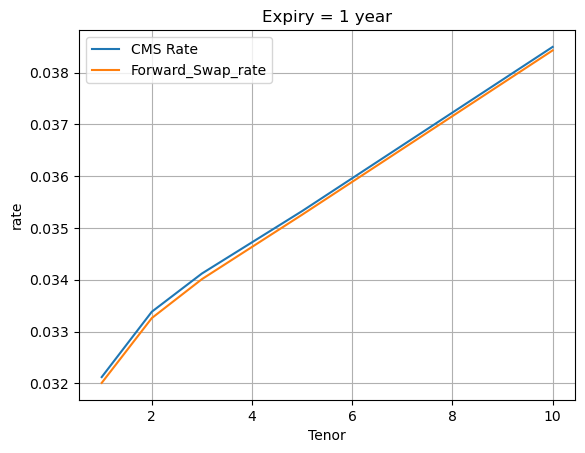

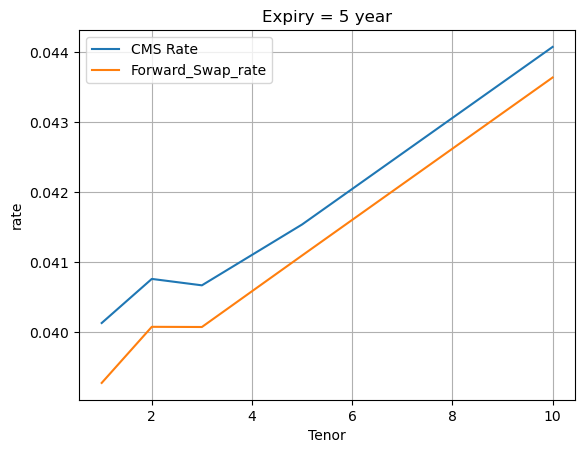

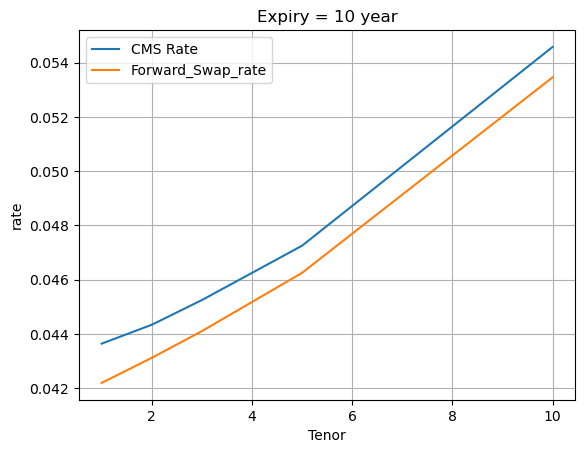

In [58]:
title_list = ['Expiry = 1 year', 'Expiry = 5 year', 'Expiry = 10 year']
for i in range(3):
    plt.plot(N,summary["CMS_rate"][i*5:(i+1)*5],label="CMS Rate")
    plt.plot(N,summary["Forward_Swap_rate"][i*5:(i+1)*5],label="Forward_Swap_rate")
    plt.title(title_list[i])
    plt.ylabel("rate")
    plt.xlabel("Tenor")
    plt.legend()
    plt.grid()
    plt.show()